<a href="https://colab.research.google.com/github/cafalchio/ETL_pipeline_disaster_response/blob/main/phd_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/seankmartin/NeuroChaT -q

     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 8.3MB 15.5MB/s 
     |████████████████████████████████| 645kB 35.8MB/s 
     |████████████████████████████████| 59.9MB 50kB/s 
     |████████████████████████████████| 317kB 35.1MB/s 


In [2]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# sys.path.insert(1, r'/code')


from neurochat.nc_datacontainer import NDataContainer
from neurochat.nc_spatial import NSpatial
import neurochat.nc_containeranalysis as nca
from neurochat.nc_control import NeuroChaT
import neurochat.nc_plot as nc_plot

# from neurochat.nc_utils import RecPos
# import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

**Cosiderations:**


For this paper we will need the main place field analyses: 

1. **location or center of mass** (it will tell us about the place remapping), 

2. **peak firing** (it will tell us about the rate remapping).

3. **PSTH** 0.05 seconds before/after the pulse. (it will tell us which cell responds to the stimulation);

4. **place field size** 

5. **number of place fields**.

##### Definitions:

*   place field defined as at least 3 neighbor bins
*   bin_size defined as 3 camera pixels
*   bins with less than 10% the peak firing of the place field were not included
*   place fields were calculated from the raw firing map (time bins / firing bins)




##### To be be improved:

*   define pyramidal cells based on waveform and firing rate
*   define place field based on sparsity, skaggs and spatial correlation



In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [96]:
#CONFIG FOLDER AND PLOT
main_dir = "/content/gdrive/MyDrive/Crossword maze data/MSC1"
plot_cells = False
dpi = 75
plot_output = ['Wave', 'Path', 'Place'] #["Wave", "Path", "Place", "HD", "LowAC", "Theta", "HighISI"]
#Place field config
bin_size = 3 # how big a bin is in cm
# If neurochat cutting away data set chop_bound to 0
chop_bound = 0
filter_ = ("b", 3)
firing_rate_needed_for_place_field = 0.1
min_place_field_neighbours = 3
# Calculates place field after smoothing if True
smooth_place = False
kwargs = {
    "pixel": bin_size,
    "chop_bound": chop_bound,
    "filter": filter_,
    "fieldThresh": firing_rate_needed_for_place_field,
    "minPlaceFieldNeighbours": min_place_field_neighbours,
    "smoothPlace": smooth_place,
}

#### Run in batch

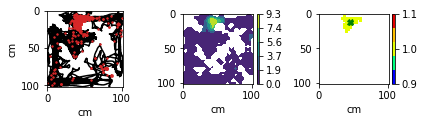

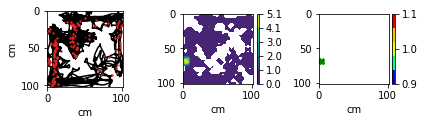

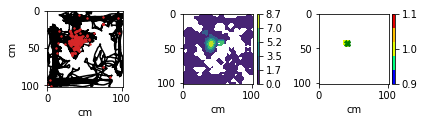

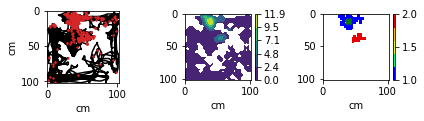

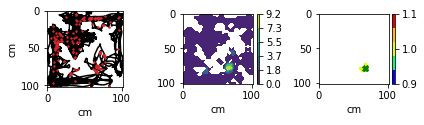

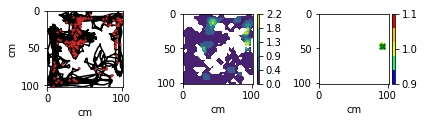

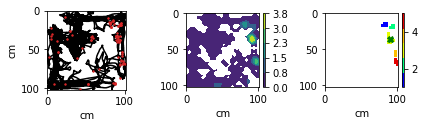

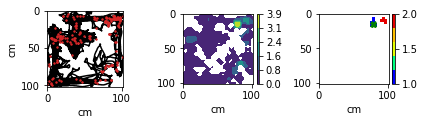

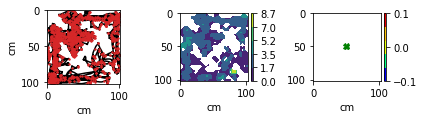

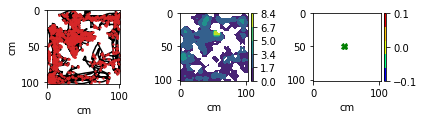

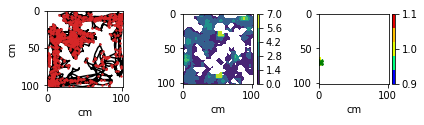

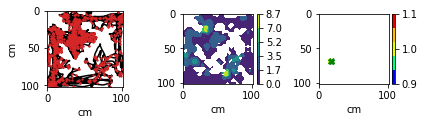

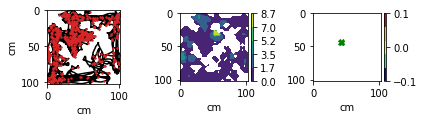

In [104]:
results = {
    "file": [], #Filename
    "tetrode": [], # Tetrode number
    "cell": [], # Cell number
    "field_number": [], # Number of place field analysed
    "centre_x": [], # centre of mass, cord x in cm
    "centre_y": [], # centre of mass, cord y in cm
    "pf_size" : [], # place field size in bins units
    "pf_n_spks": [],# number of spikes in the place field
    "pf_peak_frate": [] # place field peak firing rate
  }



container = NDataContainer(load_on_fly=True)
container.add_axona_files_from_dir(main_dir, recursive=True, verbose=False)
container.setup()
if plot_cells:
    nca.place_cell_summary(container, output=plot_output, dpi=dpi, out_dirname="plot_cells")
    
for i, data in enumerate(container):
    data_idx, unit_idx = container._index_to_data_pos(i)
    filename = container.get_file_dict()["Spike"][data_idx][0]
    result_file, tetrode_number = container.get_file_dict()["Spike"][data_idx][0].split('/')[-1].split('.')
    unit_number = container.get_units(data_idx)[unit_idx]
    spike_times = data.spike.get_timestamp(unit_number)
    place_data = data.place(**kwargs)
    bin_area = bin_size
    f_dir = os.path.dirname(filename)
    data_basename = (result_file + "_" + tetrode_number + "_" +
                            str(unit_number) + ".jpg")
    # Firing map stuff
    firing_map = place_data["firingMap"]
    smoothed_firing_map = place_data["smoothMap"]

    # Place field stuff
    largest_place_field_number = place_data["largestPlaceGroup"]
    place_fields = place_data["placeField"]

    # print(f'{result_file} - tet: {tetrode_number} - unit: {unit_number}')
    # fig, axes = plt.subplots(1, 3)
    # # 1 Firing map
    # axes[0].imshow(firing_map)
    # axes[0].set_title("Firing Map")

    # # 2 Smooth map
    # axes[1].imshow(smoothed_firing_map)
    # axes[1].set_title("Smooth Firing Map")

    # # 3 Place field
    # axes[2].imshow(place_fields)
    # axes[2].set_title("Place fields")
    # plt.show()
    # plt.close()
    ax = nc_plot.loc_firing_and_place(place_data)
    plt.savefig(f_dir+'/'+'nc_results'+'/'+data_basename)
    plt.show()
    plt.close()
    #Assume more than one place field
    tmap = place_data["tmap"]
    # How many place fields
    num_place_fields = np.unique(place_fields).size - 1
    # num_place_fields = 1
    # print(f"num_place_fields: {num_place_fields}")
    place_field_results = {}
    if smooth_place:
        pmap = smoothed_firing_map
    else:
        pmap = firing_map
    pmap[tmap == 0] = None
    spike_counts = place_data["spikeCounts"].astype(int)
        
    for i in range(1, num_place_fields + 1):
        centroid = NSpatial.place_field_centroid(place_fields, pmap, i)
        centroid = centroid * bin_size + (bin_size * 0.5)
        # flip x and y
        centroid = centroid[::-1]
        bins_in_place_field = np.array(np.where(place_fields == i))     
        place_field_size = bins_in_place_field.size
        # Our own code - TODO update NC
        spike_counts_place_field = spike_counts[
            bins_in_place_field[0], bins_in_place_field[1]]
        number_of_spikes_in_place_field = np.sum(spike_counts_place_field)
        max_firing_rate_in_place_field = pmap[
            bins_in_place_field[0], bins_in_place_field[1]].max()
        #Log results
        results["file"].append(result_file) 
        results["tetrode"].append(tetrode_number)
        results["cell"].append(unit_number)
        results["field_number"].append(i)
        results["centre_x"].append(centroid[0]) 
        results["centre_y"].append(centroid[1])
        results["pf_size"].append(place_field_size) 
        results["pf_n_spks"].append(number_of_spikes_in_place_field)
        results["pf_peak_frate"].append(max_firing_rate_in_place_field)
    if i >=10:
      break
df = pd.DataFrame(results)
df.to_csv(f_dir+'/'+'nc_results'+'/result.csv', index=False)

In [105]:
df

,file,tetrode,cell,field_number,centre_x,centre_y,pf_size,pf_n_spks,pf_peak_frate
0,031117-MSC1-big-1-baseline,1,1,1,45.730017,12.895593,72,230,17.948718
1,031117-MSC1-big-1-baseline,1,2,1,3.841601,69.028949,8,9,21.428571
2,031117-MSC1-big-1-baseline,1,3,1,40.928507,43.065447,14,193,15.060241
3,031117-MSC1-big-1-baseline,1,4,1,39.365736,10.433941,104,324,20.689655
4,031117-MSC1-big-1-baseline,1,4,2,54.686007,37.809449,34,169,12.204724
5,031117-MSC1-big-1-baseline,1,5,1,66.655094,78.470557,16,19,35.000000
6,031117-MSC1-big-1-baseline,1,7,1,91.500000,47.192308,6,4,8.333333
7,031117-MSC1-big-1-baseline,3,1,1,81.924239,15.377737,10,10,8.333333
8,031117-MSC1-big-1-baseline,3,1,2,93.117301,18.770242,6,11,5.263158
9,031117-MSC1-big-1-baseline,3,1,3,90.982149,34.870910,18,18,11.538462
